<a href="https://colab.research.google.com/github/bearbearyu1223/Graph-Neural-Network-Study-Notes/blob/main/self_attention_for_graph_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks

[Graph Attention Networks (GATs)](https://arxiv.org/abs/1710.10903) is a noval neural network architecture that operates on graph-structured data and leverage masked self-attention layers to address the shortcomings of prior methods based on Graph Convolutions or their approximations. 

The main idea begind GATs is that some neighors are more important than others, regarless of their node degrees. 

## 1. Import Libraries 


In [1]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import numpy as np
np.random.seed(0)

import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 12})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 2. Graph Dataset - CiteSeer



* [Cora](http://www.kamalnigam.com/papers/cora-jnl.pdf): it consists of 2,708 
machine learning papers that belong to one of seven categories. Node features represent the presence (1) or absence (0) of 1,433 words in a paper (binary bag of words).
* [CiteSeer](https://clgiles.ist.psu.edu/papers/DL-1998-citeseer.pdf): it is a bigger but similar dataset of 3,327 scientific papers to classify into one of six categories. Node features represent the presence (1) or absence (0) of 3,703 words in a paper.
* [PubMed](http://eliassi.org/papers/ai-mag-tr08.pdf): it is an even bigger dataset with 19,717 scientific publications about diabetes from PubMed's database, classified into three categories. Node features are TF-IDF weighted word vector from a dictionary of 500 unique words.

These datasets have been widely used by the research community for benchmarking of their GNNs performance. We can directly import any of these datasets in PyTorch Geometric with the [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) class. 

We will use [CiteSeer](https://clgiles.ist.psu.edu/papers/DL-1998-citeseer.pdf) dataset in this notebook.


In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Is graph directed: {data.is_directed()}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of edges: {data.edge_index.size()[1]}')
print(f'Number of features: {dataset.num_features}')
# There are 6 classes in citeseer dataset : Agents, Artificial Intelligence, Database, Human Computer Interaction, Machine Learning and Information Retrieval
print(f'Number of classes: {dataset.num_classes}')
print(f'Classes: {set(data.y.tolist())}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Number of graphs: 1
Is graph directed: False
Number of nodes: 3327
Number of edges: 9104
Number of features: 3703
Number of classes: 6
Classes: {0, 1, 2, 3, 4, 5}
Has isolated nodes: True


<BarContainer object of 32 artists>

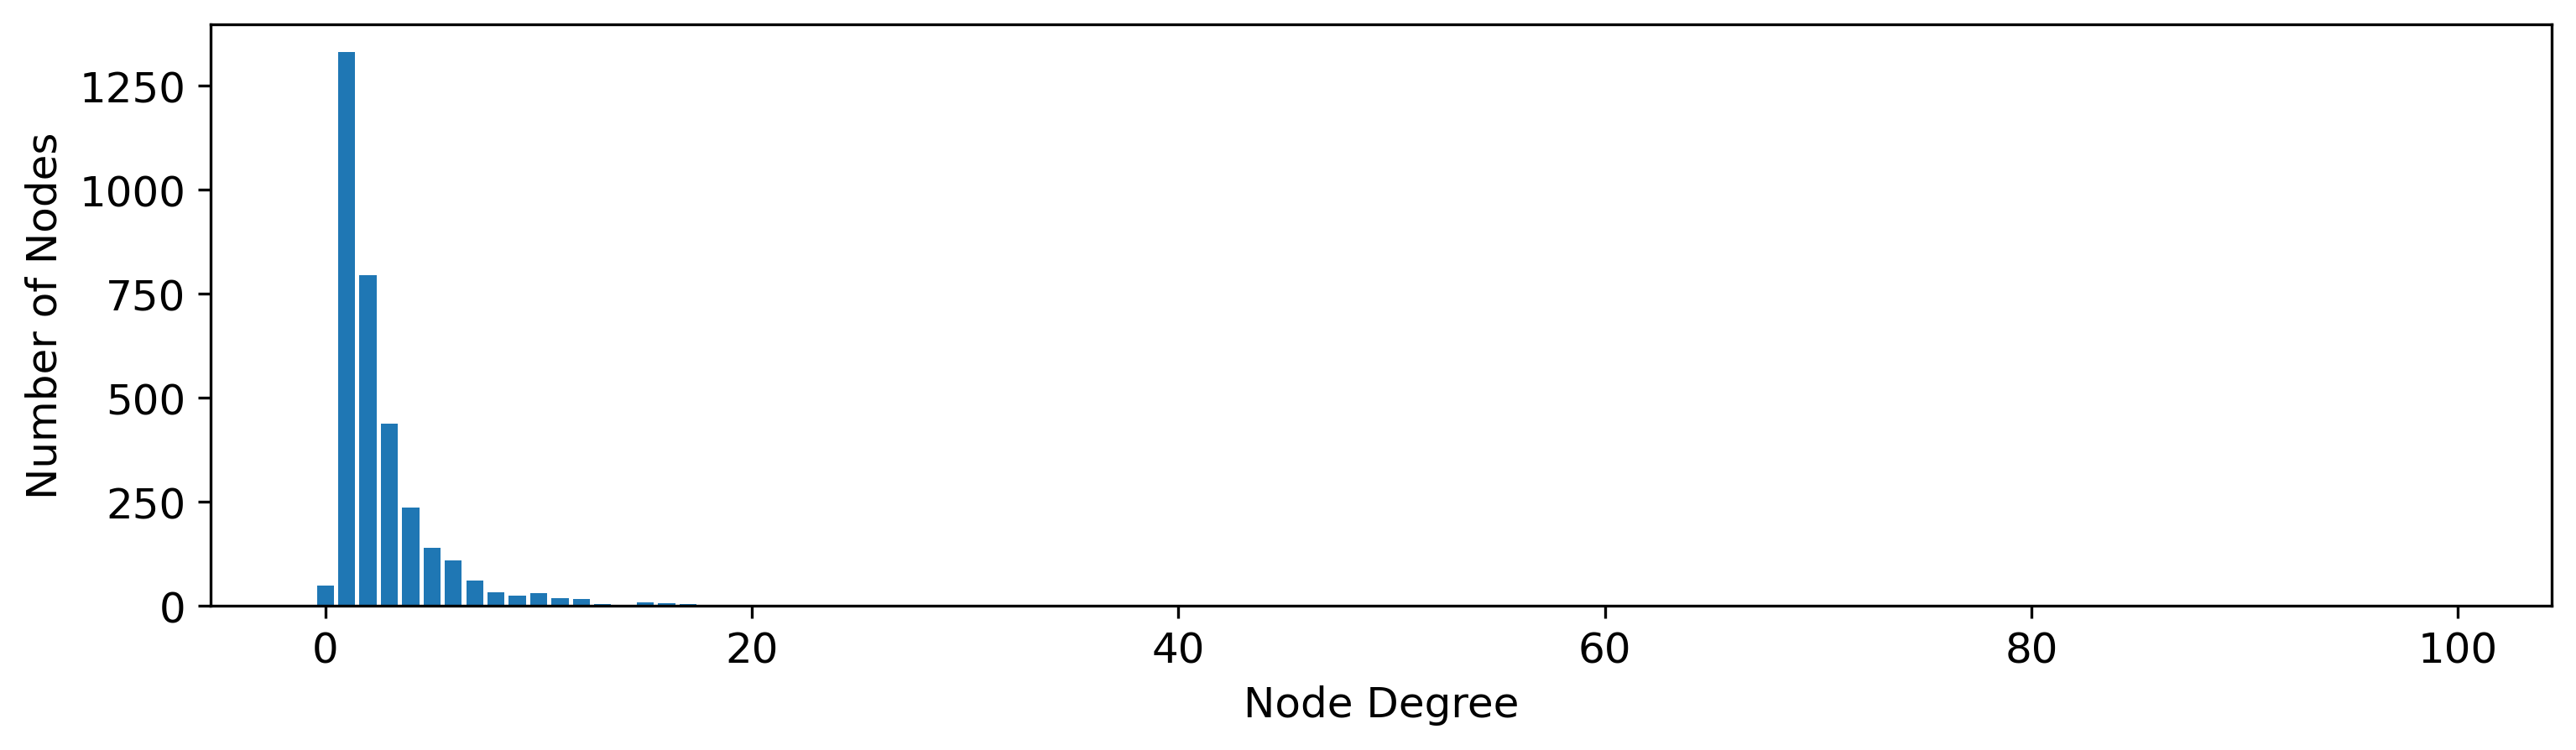

In [3]:
# Plot the number of connections of each node (a.k.a, degree of a node)
from torch_geometric.utils import degree
from collections import Counter

degrees = Counter(degree(data.edge_index[0]).numpy())
fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel("Node Degree")
ax.set_ylabel("Number of Nodes")
plt.bar(degrees.keys(), 
        degrees.values())

In [4]:
# visualize the graph 
from torch_geometric.utils import to_networkx

def visualize_graph(data):
  G = to_networkx(data, to_undirected=True)
  plt.figure(figsize=(10, 10))
  plt.axis("off")
  nx.draw_networkx(G, 
      pos = nx.spring_layout(G, seed=0), 
      with_labels = False, 
      node_size = 8, 
      node_color = data.y, 
      cmap = "hsv", 
      vmin = -2, 
      vmax = 3, 
      width = 0.8, 
      edge_color = "grey"
  )
  plt.show()

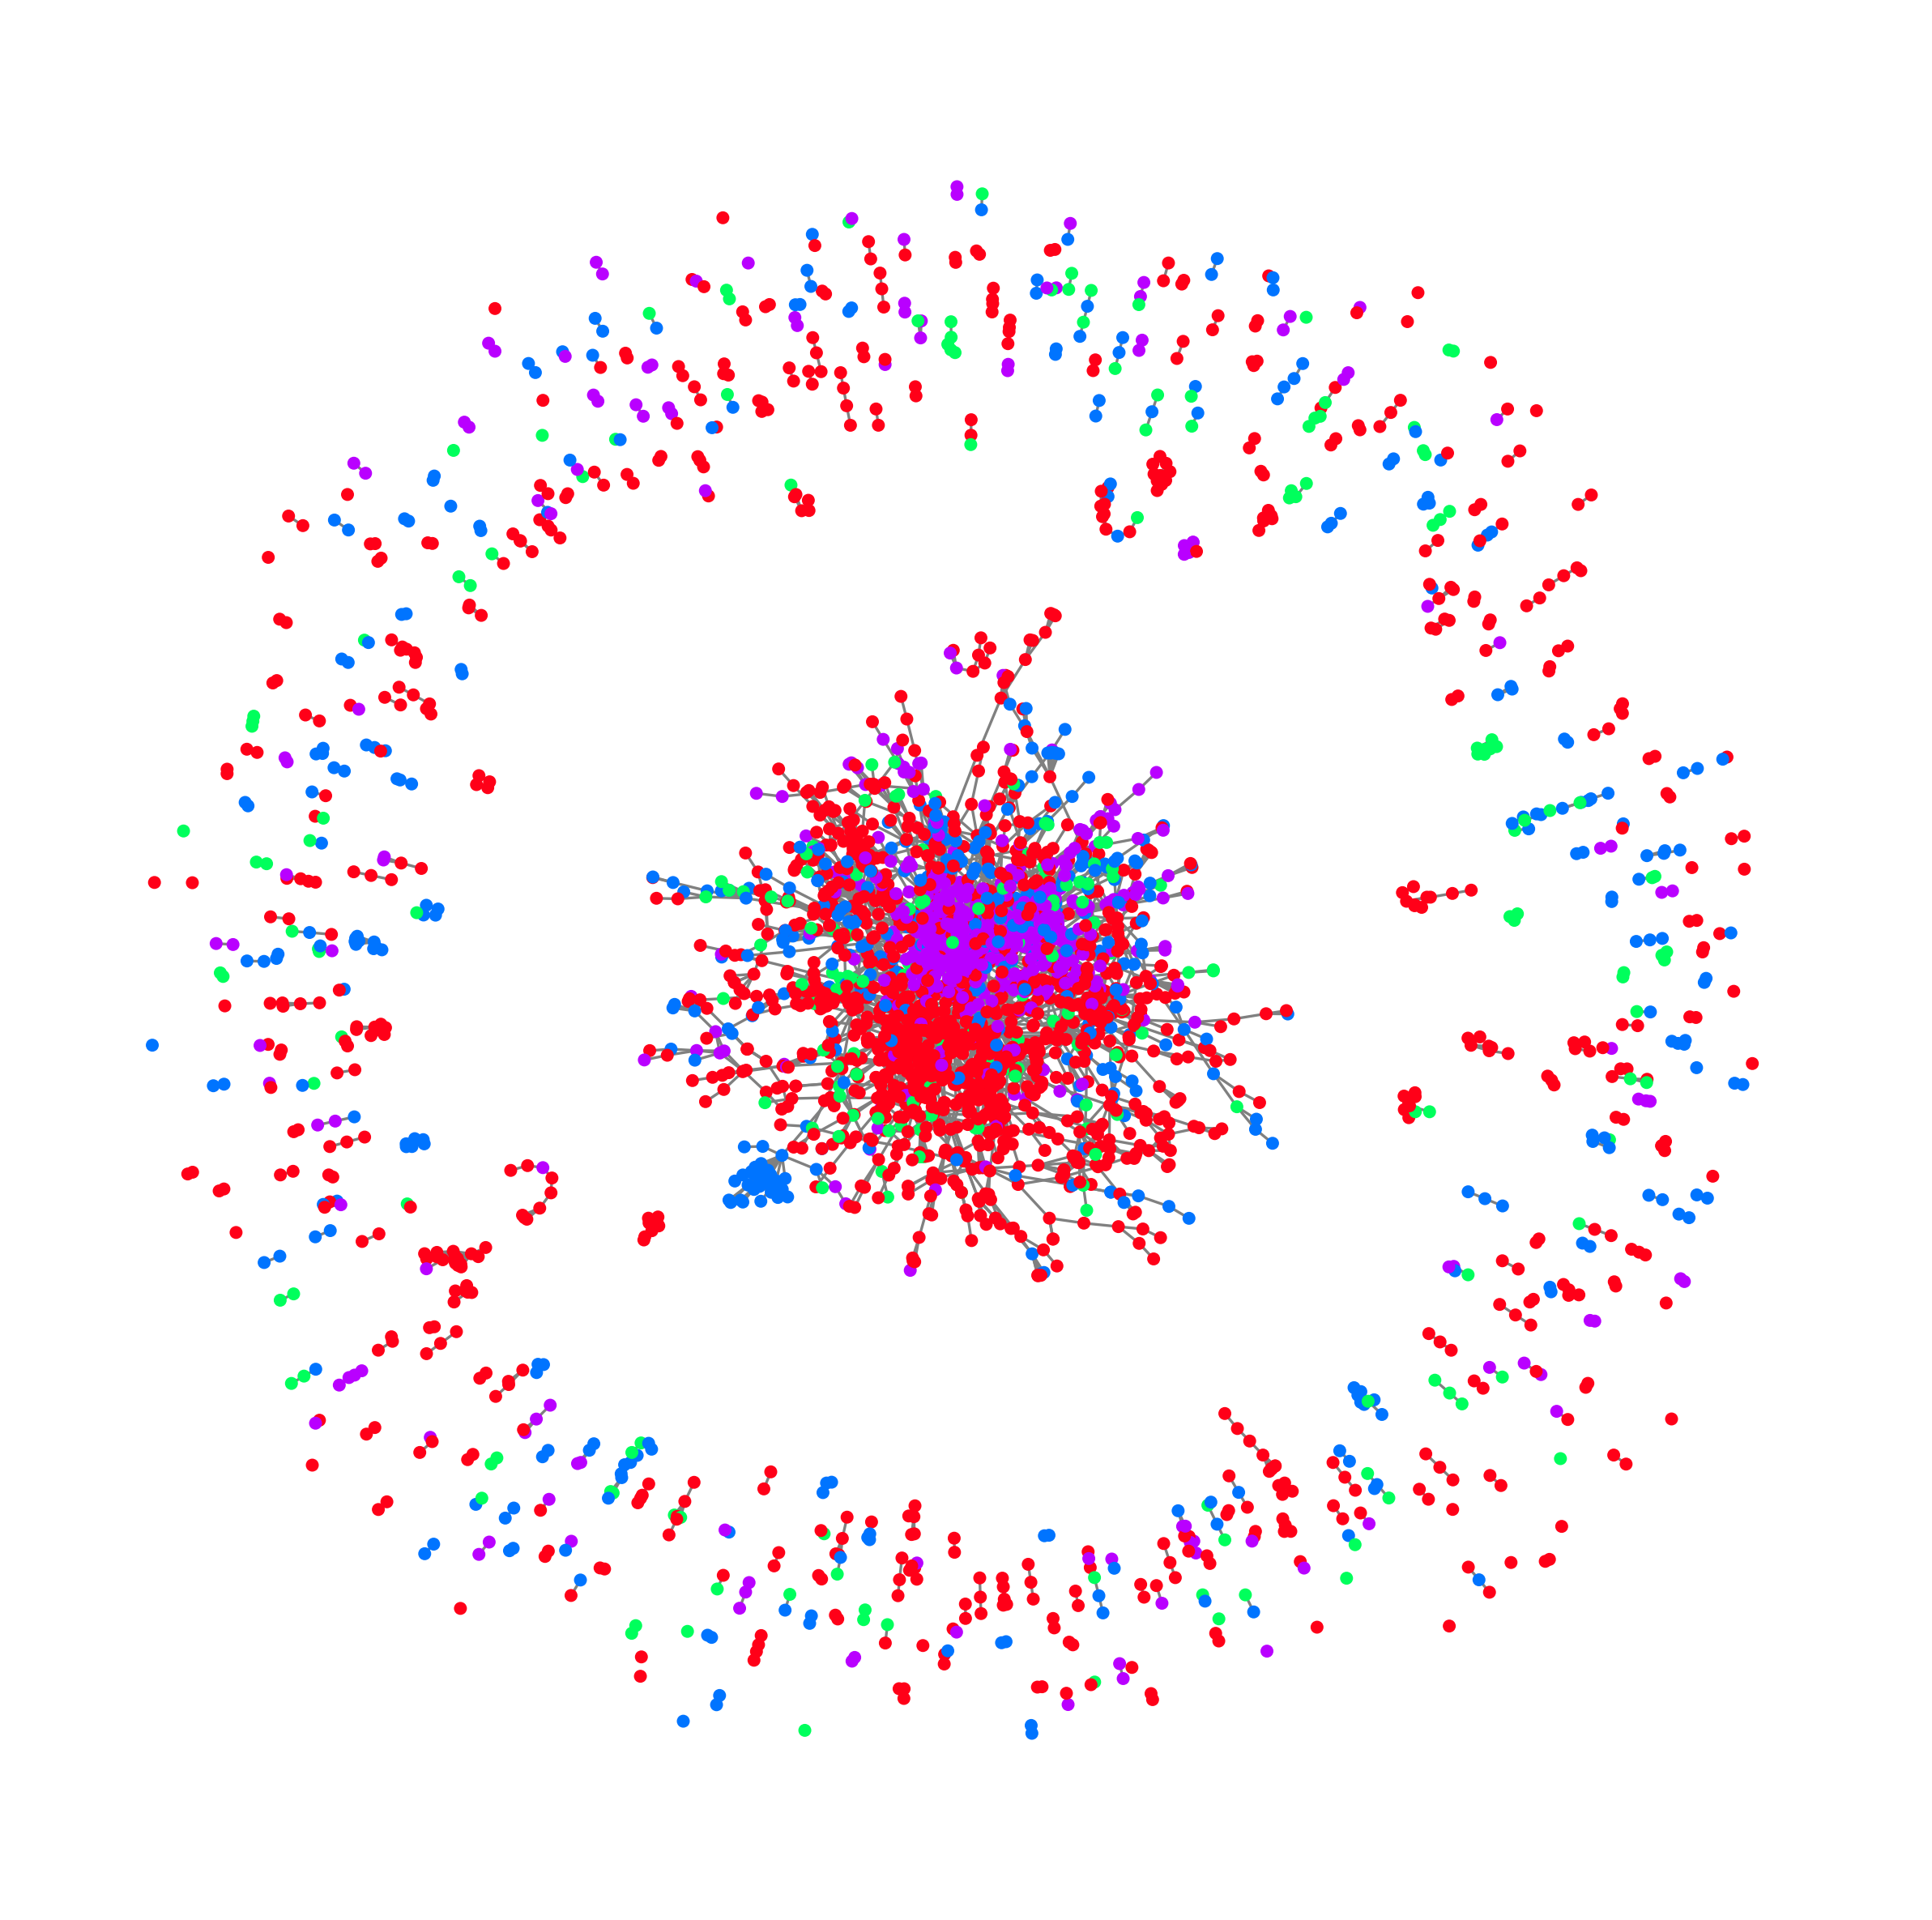

In [5]:
visualize_graph(data)

## 3. Graph Attention Layer
Introduced in [Graph Attnetion Networks](https://arxiv.org/abs/1710.10903), self-attention in GATs relies on a simple idea: some nodes are more important than other.Self-attention calcuates *the importance of neighbor nodes features  $x_j, j\in N_i$ to node $i$*. Let $\alpha_{ij}$ denotes the importance of node $j's$ features to node $i$, and let $x_i$ denotes the feature vector of node $i$. The graph attention layer calculates the embeddings of node $i$ as a sum of attention weighted features from neighbor nodes: 

$\displaystyle h_i=\alpha_{ii}Wx_i + \sum_{j\in N_i} \alpha_{ij}Wx_j$

In details, there are four steps to learn the attention coefficients:

* **Linear Transformation**- apply a new linear transformation with a weight matrix $W_{att}$:
$\displaystyle \alpha_{ij} = W_{att}[Wx_i||Wx_j]$
* **Activation**-- add nonlinearity with an activation function sunc as *LeakyReLU*: $\displaystyle e_{ij} = LeakyReLU(α_{ij})$
* **Softmax Normalization**-- normalize the outputs so that we can compare those coefficients using the same scale: $\displaystyle \alpha_{ij}=softmax(e_{ij})=\frac{exp(e_{ij})}{\sum_{j\in N_i}exp(e_{ij})}$
* **Multi-head Attention**- Borrow the same ideas as introduced in [Attention is All You need](https://arxiv.org/abs/1706.03762), GATs can be further improved using multi-head attention(e.g.,  expand the expressiveness and stability of attention via looking at different segments of the features vector). In GATs, multi-head attention consists of replicating the same 3 steps (Linear Transformation, Activation, Normalization) several times so that instead of a single embedding $h_i$, we get one embedding per attention head (denoted as $h^k_i$ for the head $k$); then we can further calculate the embedding $h_i$ by averaging or concatenate the attenntion heads: 
$\displaystyle h_i = \frac{1}{n}\sum^n_{k=1}h^k_i$ or  $\displaystyle h_i = ||\sum^n_{k=1}h^k_i$, where $n$ is the number of heads. 


## 4. Implementation of a GAT

In [6]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import  GCNConv, GATv2Conv    

In [7]:
class GCN(torch.nn.Module):
  '''Two Stacked Graph Convolution Layers'''
  def __init__(self, dim_in, dim_h, dim_out):
    '''
    Parameters:
      dim_in  (int) : dimension of input features
      dim_h   (int) : dimension of hidden layers 
      dim_out (int) : dimension of outputs
    '''
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.2, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

In [8]:
class GAT(torch.nn.Module): 
  '''Two Stacked Graph Attention Layers'''
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    '''
    Parameters:
      dim_in  (int) : dimension of input features
      dim_h   (int) : dimension of hidden layers 
      dim_out (int) : dimension of outputs
      heads   (int) : number of multi-heads attention 
    '''
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
  
  def forward(self, x, edge_index): 
    h = self.gat1(x, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.2, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

In [9]:
def accuracy(pred_y, y): 
  '''Calculate the prediction accuracy'''
  return ((pred_y == y).sum()/len(y)).item()

In [10]:
def train(model, data, epochs=200):
  '''Train a GNN model and return the trained model'''
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = model.optimizer

  model.train()
  for epoch in range(epochs+1): 
    optimizer.zero_grad()
    _, out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

    if(epoch % 10 == 0):
      print(f'Epoch {epoch:>3} |'
            f' Train Loss: {loss:.3f} |'
            f' Train Acc: {acc*100:>6.2f}% |'
            f' Val Loss: {val_loss:.3f} |'
            f' Val Acc: {val_acc*100:>6.2f}%')
  return model

In [11]:
@torch.no_grad()
def test(model, data):
  '''Evaluate the model on test set'''
  model.eval()
  _, out = model(data.x, data.edge_index)
  acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
  return acc

In [12]:
%%time
# train a GNN model via GCNs 
gcn = GCN(dim_in=dataset.num_features, dim_h=16, dim_out=dataset.num_classes)
print(gcn)
train(gcn, data)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.787 | Train Acc:  15.00% | Val Loss: 1.777 | Val Acc:  21.60%
Epoch  10 | Train Loss: 0.226 | Train Acc:  98.33% | Val Loss: 1.099 | Val Acc:  64.00%
Epoch  20 | Train Loss: 0.039 | Train Acc: 100.00% | Val Loss: 1.126 | Val Acc:  63.80%
Epoch  30 | Train Loss: 0.021 | Train Acc:  99.17% | Val Loss: 1.211 | Val Acc:  65.80%
Epoch  40 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 1.194 | Val Acc:  65.00%
Epoch  50 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 1.210 | Val Acc:  61.00%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 1.141 | Val Acc:  66.00%
Epoch  70 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 1.141 | Val Acc:  64.20%
Epoch  80 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 1.146 | Val Acc:  65.40%
Epoch  90 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 1.129 | Val Acc:  65.60%
Epoch 100 | Train Loss: 0.015 | Train Acc: 100.00% | Val Los

In [13]:
%%time
# train a GNN model via GATs 
gat = GAT(dim_in=dataset.num_features, dim_h=8, dim_out=dataset.num_classes)
print(gat)
train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.801 | Train Acc:  15.00% | Val Loss: 1.789 | Val Acc:  19.80%
Epoch  10 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.332 | Val Acc:  63.40%
Epoch  20 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.598 | Val Acc:  64.20%
Epoch  30 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.499 | Val Acc:  64.40%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.309 | Val Acc:  63.40%
Epoch  50 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.165 | Val Acc:  66.60%
Epoch  60 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.258 | Val Acc:  66.40%
Epoch  70 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.218 | Val Acc:  66.80%
Epoch  80 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.123 | Val Acc:  68.00%
Epoch  90 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.139 | Val Acc:  67.60%
Epoch 100 | Train Loss: 0.004 | Train A